## Chapter 14: Convolutional Neural Networks

# 14.3 Convolutional neural network

In [3]:
# This code cell won't be shown in the HTML version of this notebook.
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
from mlrefined_libraries import convnets_library as convlib
from mlrefined_libraries import basics_library as baslib
import autograd.numpy as np
import pandas as pd
#import cv2
from PIL import Image
import pickle
import gzip
import time

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

Previously we discussed in full detail how to use the convolution operation to extract features based on the edge content of input images. More elaborate variations of this idea have been used effectively in practice (e.g., HoG [[1]](#bib_cell) and SIFT [[2]](#bib_cell) features) particularly for object detection, where in all cases features are computed using fixed (i.e., pre-defined) kernels. In general, employing this breed of 'engineered' features in place of raw pixel values (see Figure 1) considerably improves the overall performance of supervised/unsupervised learners, as we confirmed empirically in Section 14.2 via a simple face detection experiment.

A simple Convolutional Neural Network (CNN), as depicted in the bottom row of Figure 1, is different from the architectures we have seen so far (middle row of Figure 1) in that with CNNs, in addition to the tunable weights of the supervised/unsupervised learner, we also learn the convolutional kernels simultaneously using our training data.

<figure>
<img src="../../mlrefined_images/convnet_images/raw_fixed_CNN.png" width="80%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> Three simple pipelines for machine learning tasks involving images. (top row) Using raw pixels values as input features generally leads to subpar results. (middle row) A fixed convolutional layer (consisting of convolution, ReLU, and pooling modules) is instered between the input image and the MLP module. This is the pipeline used in Section 14.2. (bottom row) With CNNs the kernels in the convolutional layer are also tuned along with the MLP weights. The modules involving tunable weights are colored yellow. </em>
</figcaption>
</figure>

Recall from our discussion of multilayer perceptrons that we can write the ```model``` associated with a general $L$ layer MLP as 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathbf{w}_{L+1}^T\mathring{\mathbf{f}}^{(L)}
\end{equation}

where $\mathring{\mathbf{f}}^{(L)}$, as discussed in Section 13.1, is formed by tacking a $1$ on top of the feature transformation  

\begin{equation}
\mathbf{f}^{(L)} = \mathbf{a}\left(\mathbf{W}_{L}^T\mathring{\mathbf{a}}\left(\mathbf{W}_{L-1}^T\,\mathring{\mathbf{a}}\left( \cdots \mathbf{W}_{1}^T\mathring{\mathbf{x}}\right) \right)\right)
\end{equation}

Hence, to write the ```model``` associated with a simple CNN algebraically, all we need to is replace the input $\mathbf{x}$ in Equation (2) with the output of the convolutional layer given as

\begin{equation}
\text{pool}\left(\text{max}\left(0,\mathbf{W}_{conv}*\mathbf{x}\right)\right) 
\end{equation}

where $\mathbf{W}_{conv}$ represents all convolutional kernel weights to be tuned together with MLP weights $\mathbf{W}_{1},\ldots,\mathbf{W}_{L}$ and $\mathbf{w}_{L+1}$.

That the convolutional kernels are learned to the data with CNNs implies we should intuitively expect them to outperform their fixed kernel counterparts - a hypothesis we now put to test through a simple experiment.

#### <span style="color:#a50e3e;">Example 1. </span>  CNN vs. fixed

Here we show how learning the parameters of our kernels can improve validation accuracy on the MNIST dataset.  In particular here repeat the experiment of Example 1 in the previous Section using the training portion of MNIST (consisting of $60,000$ images) and the same train / validation split as used there.  The difference here is that we will now learn the parameters of our kernel.  Previously - when using fixed kernels - we were able to achieve a $96.5\%$ accuracy on the validation set.  By learning the kernels we improve this significantly - attaining a $97.8\%$ accuracy on the same validation set.

<IPython.core.display.Javascript object>


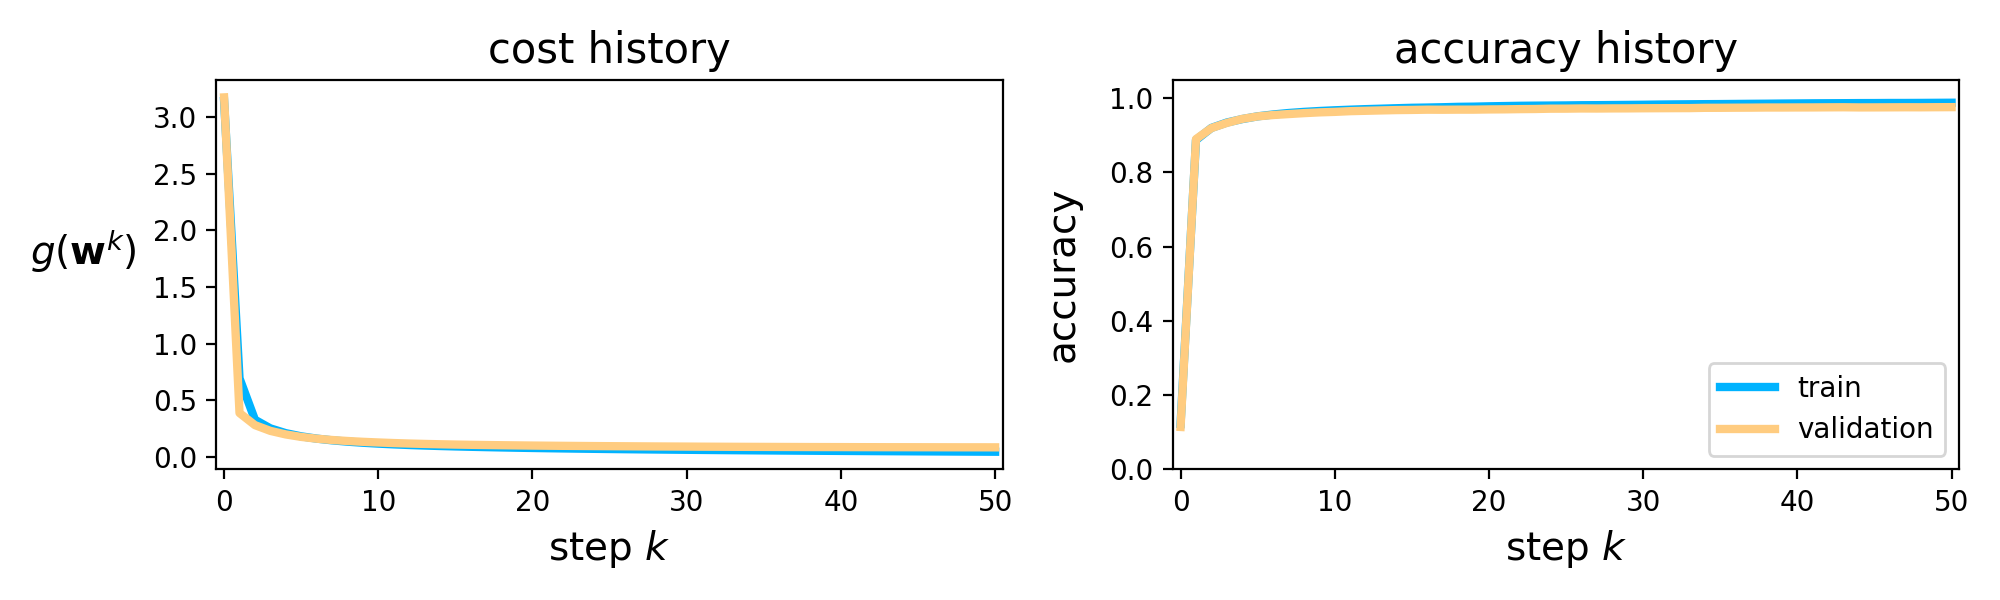

In [212]:
## This code cell will not be shown in the HTML version of this notebook
## This code cell will not be shown in the HTML version of this notebook
#### run on pixels #####
# load data
datapath = 'datasets/mnist_data.csv'
data = np.loadtxt(datapath,delimiter = ',')

# import data and reshape appropriately
x = data[:-1,:]
y = data[-1:,:] 

# subsample
P = np.size(y) 
inds = np.random.permutation(60000)[:P]
inds = np.arange(0,60000)
x_sample = x[:,inds]
y_sample = y[:,inds]

# contrast normalize images
normalizer,inverse_normalizer = convlib.normalizers.standard(x_sample.T)
x_sample = normalizer(x_sample.T).T

# import the v1 library
mylib1 = convlib.convnet_lib.Setup(x_sample,y_sample)

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10]
mylib1.choose_features(name = 'multilayer_perceptron_batch_normalized',layer_sizes = layer_sizes,super_type = 'classification',activation = 'maxout',scale = 0.5)

# split into training and testing sets
mylib1.make_train_val_split(train_portion = 0.8)

# choose normalizer
mylib1.choose_normalizer(name = 'ZCA_sphere')

# choose cost
mylib1.choose_cost(name = 'multiclass_softmax')

# fit an optimizationx
mylib1.fit(max_its = 100,alpha_choice = 10**(1),batch_size = 500)

# plot cost history
mylib1.show_histories(start = 0,labels = ['run 1'])

##### run with fixed kernel extraction #####
# This code cell won't be shown in the HTML version of this notebook.
kernels = np.array([
       [[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[-1, -1,  0],
        [-1,  0,  1],
        [ 0,  1,  1]],
    
        [[-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1]],

       [[ 0,  1,  1],
        [-1,  0,  1],
        [-1, -1,  0]],

       [[ 1,  0, -1],
        [ 1,  0, -1],
        [ 1,  0, -1]],

       [[ 0, -1, -1],
        [ 1,  0, -1],
        [ 1,  1,  0]],

       [[ 1,  1,  1],
        [ 0,  0,  0],
        [-1, -1, -1]],

       [[ 1,  1,  0],
        [ 1,  0, -1],
        [ 0, -1, -1]]])        

# import the v1 library
mylib2 = setup5.Setup(x_sample,y_sample)

# choose convolution layers
kernel_sizes = [8,3,3]
mylib2.choose_convolutions(kernel_sizes = kernel_sizes,kernels = kernels)

# send data through fixed kernels
x_trans = mylib2.conv_layer(mylib1.x.T,kernels).T

# import the v1 library
mylib2 = convlib.convnet_lib.Setup(x_trans,y_sample)

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10]
mylib2.choose_features(name = 'multilayer_perceptron_batch_normalized',layer_sizes = layer_sizes,super_type = 'classification',activation = 'maxout',scale = 0.5)

# split into training and testing sets
mylib2.x_train = mylib2.x[:,mylib1.train_inds]
mylib2.y_train = mylib2.y[:,mylib1.train_inds]
mylib2.x_val = mylib2.x[:,mylib1.val_inds]
mylib2.y_val = mylib2.y[:,mylib1.val_inds]

# choose normalizer
mylib2.choose_normalizer(name = 'ZCA_sphere')

# choose cost
mylib2.choose_cost(name = 'multiclass_softmax')

# fit an optimizationx
mylib2.fit(max_its = 100,alpha_choice = 10**(1),batch_size = 500)

# plot cost history
mylib2.show_histories(start = 0,labels = ['run 1'])

#### learned kernel example #####
# import the lib
mylib3 = conv.Setup(x_sample,y_sample)

# choose convolution layers
kernel_sizes = [8,3,3]
mylib3.choose_convolutions(kernel_sizes = kernel_sizes)

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [10]
mylib3.choose_features(name = 'multilayer_perceptron_batch_normalized',layer_sizes = layer_sizes,super_type = 'classification',activation = 'maxout',scale = 0.5)

# # split into training and testing sets
mylib3.x_train = mylib1.x_train
mylib3.y_train = mylib1.y_train
mylib3.x_val = mylib1.x_val
mylib3.y_val = mylib1.y_val
mylib3.make_train_val_split(train_portion = 0.8)

# choose normalizer
mylib3.choose_normalizer(name = 'ZCA_sphere')

# choose cost
mylib3.choose_cost(name = 'multiclass_softmax')

# fit an optimizationx
mylib3.fit(max_its = 50,alpha_choice = 10**(0),batch_size = 500)

# plot cost history
mylib3.show_histories(start = 0,labels = ['run 1'])

# plot cost history
mylib3.show_histories(start = 0,labels = ['run 1'])

<a id='bib_cell'></a>

## References

[1] Navneet Dalal and Bill Triggs. Histograms of oriented gradients for human detection. In
Computer Vision and Pattern Recognition, 2005. CVPR 2005. IEEE Computer Society
Conference on, volume 1, pp. 886–893. IEEE, 2005

[2] David G. Lowe. Distinctive image features from scale-invariant keypoints. International Journal of Computer Vision, 60(2) 91–110, 2004